In [4]:
!pip install transformers

In [5]:
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
file_path = '/content/drive/MyDrive/reviewContent+metadataBalanced.csv'
df = pd.read_csv(file_path)

In [8]:
df

,user_id,prod_id,rating,label,date,text_
0,5044,0,1,0,11/16/2014,"Drinks were bad, the hot chocolate was watered..."
1,5045,0,1,0,9/8/2014,This was the worst experience I've ever had a ...
2,5046,0,3,0,10/6/2013,This is located on the site of the old Spruce ...
3,5047,0,5,0,11/30/2014,I enjoyed coffee and breakfast twice at Toast ...
4,5048,0,5,0,8/28/2014,I love Toast! The food choices are fantastic -...
...,...,...,...,...,...,...
160927,265253,5041,5,0,11/15/2011,Great local lounge spot! After work and regula...
160928,265316,5042,5,0,12/24/2014,I have been to this place for the third time i...
160929,62901,5043,1,0,8/4/2011,Horrible service. I saw a customer accidentall...
160930,201246,5043,2,0,4/14/2013,Its your standard late-night drunk filled coll...


In [9]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text_'], df['label'],
                                                                    random_state=1,
                                                                    test_size=0.2,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=1,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [10]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

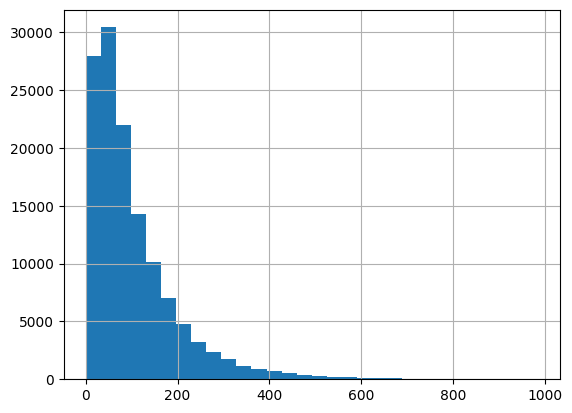

In [11]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [12]:
max_seq_len = 128

In [13]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [15]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [16]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [17]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [18]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [19]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
#class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

#print(class_wts)
"""
class_wts = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )
class_wts = dict(zip(np.unique(train_labels), class_wts))

"""
class_wts = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)


In [21]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 4

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [23]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  total_labels = []

  total_preds_train = []

  total_labels_train = []

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # append the true labels
    total_labels.extend(labels.cpu().numpy())

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds = np.concatenate(total_preds, axis=0)

  # calculate training metrics
  accuracy = accuracy_score(total_labels, np.argmax(total_preds, axis=1))
  precision = precision_score(total_labels, np.argmax(total_preds, axis=1), average='weighted')
  recall = recall_score(total_labels, np.argmax(total_preds, axis=1), average='weighted')
  f1 = f1_score(total_labels, np.argmax(total_preds, axis=1), average='weighted')

  print(f'Training Loss: {avg_loss:.3f}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')

  #returns the loss and predictions
  return avg_loss, total_preds

In [24]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # empty lists to save true labels
  total_labels = []

  total_preds_val = []

  total_labels_val = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

      # append the true labels
      total_labels.extend(labels.cpu().numpy())

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)


  # calculate validation metrics
  accuracy = accuracy_score(total_labels, np.argmax(total_preds, axis=1))
  precision = precision_score(total_labels, np.argmax(total_preds, axis=1), average='weighted')
  recall = recall_score(total_labels, np.argmax(total_preds, axis=1), average='weighted')
  f1 = f1_score(total_labels, np.argmax(total_preds, axis=1), average='weighted')

  print(f'Validation Loss: {avg_loss:.3f}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')

  return avg_loss, total_preds

In [25]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# empty lists to save true labels
total_labels_train = []
total_labels_val = []

# empty lists to save model predictions
total_preds_train = []
total_preds_val = []

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, preds_train = train()
    total_labels_train.extend(train_labels.values)
    #total_labels_train.extend(labels.cpu().numpy())
    total_preds_train.extend(preds_train)

    #evaluate model
    valid_loss, preds_val = evaluate()
    #total_labels_val.extend(val_labels.cpu().numpy())
    total_labels_val.extend(val_labels.values)
    total_preds_val.extend(preds_val)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 4
  Batch    50  of  4,024.
  Batch   100  of  4,024.
  Batch   150  of  4,024.
  Batch   200  of  4,024.
  Batch   250  of  4,024.
  Batch   300  of  4,024.
  Batch   350  of  4,024.
  Batch   400  of  4,024.
  Batch   450  of  4,024.
  Batch   500  of  4,024.
  Batch   550  of  4,024.
  Batch   600  of  4,024.
  Batch   650  of  4,024.
  Batch   700  of  4,024.
  Batch   750  of  4,024.
  Batch   800  of  4,024.
  Batch   850  of  4,024.
  Batch   900  of  4,024.
  Batch   950  of  4,024.
  Batch 1,000  of  4,024.
  Batch 1,050  of  4,024.
  Batch 1,100  of  4,024.
  Batch 1,150  of  4,024.
  Batch 1,200  of  4,024.
  Batch 1,250  of  4,024.
  Batch 1,300  of  4,024.
  Batch 1,350  of  4,024.
  Batch 1,400  of  4,024.
  Batch 1,450  of  4,024.
  Batch 1,500  of  4,024.
  Batch 1,550  of  4,024.
  Batch 1,600  of  4,024.
  Batch 1,650  of  4,024.
  Batch 1,700  of  4,024.
  Batch 1,750  of  4,024.
  Batch 1,800  of  4,024.
  Batch 1,850  of  4,024.
  Batch 1,900  of  4,024

In [26]:
# calculate training metrics
accuracy_train = accuracy_score(total_labels_train, np.argmax(total_preds_train, axis=1))
precision_train = precision_score(total_labels_train, np.argmax(total_preds_train, axis=1), average='weighted')
recall_train = recall_score(total_labels_train, np.argmax(total_preds_train, axis=1), average='weighted')
f1_train = f1_score(total_labels_train, np.argmax(total_preds_train, axis=1), average='weighted')

# calculate validation metrics
accuracy_val = accuracy_score(total_labels_val, np.argmax(total_preds_val, axis=1))
precision_val = precision_score(total_labels_val, np.argmax(total_preds_val, axis=1), average='weighted')
recall_val = recall_score(total_labels_val, np.argmax(total_preds_val, axis=1), average='weighted')
f1_val = f1_score(total_labels_val, np.argmax(total_preds_val, axis=1), average='weighted')

print(f'Training Metrics - Accuracy: {accuracy_train:.3f}, Precision: {precision_train:.3f}, Recall: {recall_train:.3f}, F1: {f1_train:.3f}')
print(f'Validation Metrics - Accuracy: {accuracy_val:.3f}, Precision: {precision_val:.3f}, Recall: {recall_val:.3f}, F1: {f1_val:.3f}')

Training Metrics - Accuracy: 0.501, Precision: 0.501, Recall: 0.501, F1: 0.500
Validation Metrics - Accuracy: 0.646, Precision: 0.646, Recall: 0.646, F1: 0.646


In [27]:
# Calculate and print the classification report
train_classification_report = classification_report(total_labels_train, np.argmax(total_preds_train, axis=1))
valid_classification_report = classification_report(total_labels_val, np.argmax(total_preds_val, axis=1))

print("\nTraining Classification Report:")
print(train_classification_report)

print("\nValidation Classification Report:")
print(valid_classification_report)


Training Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50    257492
           1       0.50      0.49      0.50    257488

    accuracy                           0.50    514980
   macro avg       0.50      0.50      0.50    514980
weighted avg       0.50      0.50      0.50    514980


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64     32184
           1       0.64      0.66      0.65     32188

    accuracy                           0.65     64372
   macro avg       0.65      0.65      0.65     64372
weighted avg       0.65      0.65      0.65     64372



In [28]:
!pip install azureml-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.4/192.4 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.0/933.0 kB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [29]:
import os
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
import json
# import torch.optim as optim
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig
# from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, f1_score, recall_score, precision_score,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
import matplotlib.pyplot as plt
from azureml.core import Workspace, Run, Dataset
from azureml.core.model import Model
import warnings
warnings.filterwarnings("ignore")

class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
model = model.to(device)
model.load_state_dict(torch.load('saved_weights.pt'))

<All keys matched successfully>

In [31]:

# Put the model in evaluation mode
model.eval()

# Create a DataLoader for the test set
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [32]:
# Evaluate the model on the test set and print the classification report

def evaluate_test():
    model.eval()
    total_preds = []
    total_labels = []

    for step, batch in enumerate(test_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        total_labels.extend(labels.cpu().numpy())

    total_preds = np.concatenate(total_preds, axis=0)
    accuracy = accuracy_score(total_labels, np.argmax(total_preds, axis=1))
    precision = precision_score(total_labels, np.argmax(total_preds, axis=1), average='weighted')
    recall = recall_score(total_labels, np.argmax(total_preds, axis=1), average='weighted')
    f1 = f1_score(total_labels, np.argmax(total_preds, axis=1), average='weighted')

    print(f'Test Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')

    # Print the classification report
    test_classification_report = classification_report(total_labels, np.argmax(total_preds, axis=1))
    print("\nTest Classification Report:")
    print(test_classification_report)

# Evaluate the model on the test set and print the classification report
evaluate_test()


Test Accuracy: 0.647, Precision: 0.647, Recall: 0.647, F1: 0.647

Test Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      8047
           1       0.64      0.65      0.65      8047

    accuracy                           0.65     16094
   macro avg       0.65      0.65      0.65     16094
weighted avg       0.65      0.65      0.65     16094

